In [ ]:
!pip install tensorflow
!pip install causalml
# !pip install pyro-ppl

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
# from causalml.inference.torch import CEVAE
from causalml.inference.tf import DragonNet
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder
from lightgbm import LGBMRegressor

# DragonNet 구조

3가지 부분으로 나눠져 있는 구조.

1. 몸통(body): 특징(feature)을 추출하는 역할.
- 기본적인 은닉층으로 이뤄진 구조로 입력 데이터의 특징을 추출한다.
- 추출 된 정보는 두 개의 "머리" 부분으로 전달된다. 중요한 점은 두 머리가 이 몸통에서 나온 정보를 공유


2. 머리(head): 처치 그룹 머리 // 통제 그룹 예측
- 각 머리는 독립적으로 결과를 예측하도록 학습
- 이렇게 두 그룹을 나누어 예측함으로써, 특정 개인에게 처치를 했을 때와 안 했을 때의 결과를 각각 시뮬레이션해볼 수 있음

3. 머리(head): 성향 점수 예측
- 3번째 머리는 결과를 맞추지 않고, **"이 사람이 과연 어떤 처치를 받았을까?"** 를 예측 (=성향점수)
- 예를 들어, 특정 환자의 데이터를 보고 이 사람이 신약을 투여받았을지, 아니면 위약을 투여받았을지를 예측하는 것



## 이런 구조를 사용하는 이유 (Gemini)

성향 점수(어떤 처치를 받았는지)를 예측하는 이유
- **편향(Bias) 방지**: 모델이 결과(Y) 예측에만 너무 집중하는 것을 막아줍니다. 결과에만 집중하면 처치(T)를 결정하는 중요한 요인을 놓쳐 예측이 한쪽으로 치우칠 수 있습니다.

- **균형 잡힌 특징 학습**: **"어떤 처치를 받았을까?"**를 맞추는 훈련을 통해, 모델의 '몸통' 부분(공통 특징 추출기)이 결과와 처치 모두에 관련된 핵심 정보들을 골고루 학습하게 됩니다.

- **모델 성능 향상**: 결과적으로 더 풍부하고 균형 잡힌 정보(representation)를 바탕으로 예측하므로, 모델 전체의 예측 정확도와 안정성이 올라갑니다.

- **신뢰도 높은 인과 추론**: 처치 효과를 분석할 때 발생할 수 있는 데이터의 숨겨진 편향을 줄여, 더 신뢰할 수 있는 분석 결과를 제공합니다.


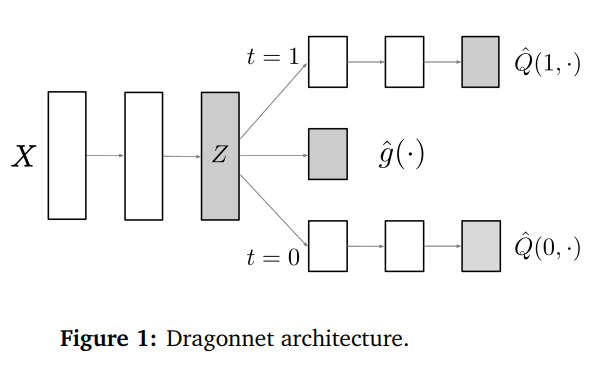

In [2]:
# load all ihdp data
df_raw = pd.DataFrame()
for i in range(1, 10):
    url = f"""https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_{i}.csv"""
    data= pd.read_csv(url, header = None)
    df_raw = pd.concat([data, df_raw])
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
df_raw.columns = cols
print(df_raw.shape)

# Deep Learning 학습을 위해 100배 복제
replications = 100
df = pd.concat([df_raw]*replications, ignore_index=True).reset_index(drop=True)
print(df.shape)

(6723, 30)
(672300, 30)


In [3]:
# 이진형 변수
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
# 연속형 변수
contfeats = [i for i in range(25) if i not in binfeats]

# reorder features
perm = binfeats + contfeats
df = df.reset_index(drop=True)
df.head()

# 반 사실 결과를 확인할 수 있는 벤치마크 데이터셋 입니다.

,treatment,y_factual,y_cfactual,mu0,mu1,0,1,2,3,4,...,15,16,17,18,19,20,21,22,23,24
0,1,49.647921,34.950762,37.173291,50.383798,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,16.073412,49.435313,16.087249,49.546234,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,19.643007,48.598210,18.044855,49.661068,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,26.368322,49.715204,24.605964,49.971196,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,20.258893,51.147418,20.612816,49.794120,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [4]:
# 딥러닝 학습용
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1
               else d['y_cfactual'] - d['y_factual'],
               axis=1).reset_index(drop=True)
# seperate for train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]



# 예측용 데이터 셋 (딥러닝 학습 예측셋이 너무 크다)
X = df_raw[perm].values
treatment = df_raw['treatment'].values
y = df_raw['y_factual'].values
y_cf = df_raw['y_cfactual'].values
tau = df_raw.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1
               else d['y_cfactual'] - d['y_factual'],
               axis=1).reset_index(drop=True)
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train_raw, treatment_train_raw, y_train_raw, y_cf_train_raw, tau_train_raw = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val= X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite]

# DragonNet

In [ ]:
DragonNet

In [5]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True, epochs= 3 )
dragon_ite = dragon.fit_predict(X_train_raw, treatment_train_raw, y_train_raw, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - binary_classification_loss: 40.0079 - loss: 30464.6191 - regression_loss: 15202.0752 - track_epsilon: 0.0379 - treatment_accuracy: 0.5831 - val_binary_classification_loss: 32.5984 - val_loss: 22887.6191 - val_regression_loss: 11465.0146 - val_track_epsilon: 0.0340 - val_treatment_accuracy: 0.8058 - learning_rate: 0.0010
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - binary_classification_loss: 32.9479 - loss: 25215.6289 - regression_loss: 12584.8486 - track_epsilon: 0.0332 - treatment_accuracy: 0.8088 - val_binary_classification_loss: 31.8780 - val_loss: 22735.9414 - val_regression_loss: 11393.6406 - val_track_epsilon: 0.0313 - val_treatment_accuracy: 0.8058 - learning_rate: 0.0010
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_classification_loss: 31.4918 - loss: 26967.5801 - regression_loss: 13462.3076 - track_epsilon: 0.0301 - treatment_accuracy: 0.8136 - val_binary_classification_loss: 33.2749 - val_loss: 23099.

In [7]:
dragon_ite_val = dragon.predict(X_val)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [6]:
dragon_ite

array([[ 7.459975 ],
       [ 8.831661 ],
       [ 4.4976616],
       ...,
       [ 8.7761345],
       [10.29785  ],
       [-1.2540197]], dtype=float32)

# 메타 러너

In [8]:
# fit propensity model
p_model = ElasticNetPropensityModel() # 성향점수
p_train = p_model.fit_predict(X_train_raw, treatment_train_raw)
p_val = p_model.fit_predict(X_val, treatment_val)

s_learner = BaseSRegressor(LGBMRegressor(verbose=-1))
s_ate = s_learner.estimate_ate(X_train_raw, treatment_train_raw, y_train_raw)[0]
s_ite_train = s_learner.fit_predict(X_train_raw, treatment_train_raw, y_train_raw)
s_ite_val = s_learner.predict(X_val)

t_learner = BaseTRegressor(LGBMRegressor(verbose=-1))
t_ate = t_learner.estimate_ate(X_train_raw, treatment_train_raw, y_train_raw)[0][0]
t_ite_train = t_learner.fit_predict(X_train_raw, treatment_train_raw, y_train_raw)
t_ite_val = t_learner.predict(X_val, treatment_val, y_val)

x_learner = BaseXRegressor(LGBMRegressor(verbose=-1))
x_ate = x_learner.estimate_ate(X_train_raw, treatment_train_raw, y_train_raw, p_train)[0][0]
x_ite_train = x_learner.fit_predict(X_train_raw, treatment_train_raw, y_train_raw, p_train)
x_ite_val = x_learner.predict(X_val, treatment_val, y_val, p_val)

r_learner = BaseRRegressor(LGBMRegressor(verbose=-1))
r_ate = r_learner.estimate_ate(X_train_raw, treatment_train_raw, y_train_raw, p_train)[0][0]
r_ite_train = r_learner.fit_predict(X_train_raw, treatment_train_raw, y_train_raw, p_train)
r_ite_val = r_learner.predict(X_val)

In [9]:
df_preds_train = pd.DataFrame([s_ite_train.ravel(),
                               t_ite_train.ravel(),
                               x_ite_train.ravel(),
                               r_ite_train.ravel(),
                               dragon_ite.ravel(),
                               tau_train_raw.ravel(),
                               treatment_train_raw.ravel(),
                               y_train_raw.ravel()],
                               index=['S','T','X','R','DragonNet','tau','w','y']).T

df_cumgain_train = get_cumgain(df_preds_train)

In [10]:
df_result_train = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate, tau_train_raw.mean()],
                               index=['S','T','X','R','DragonNet','actual'], columns=['ATE'])
df_result_train['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite_train, t_ite_train, x_ite_train, r_ite_train, dragon_ite],
                                                                  [tau_train_raw.values.reshape(-1,1)]*5 )
                          ] + [None]
df_result_train['AUUC'] = auuc_score(df_preds_train)

In [11]:
df_result_train

,ATE,MAE,AUUC
S,4.661763,4.533111,0.664618
T,4.639223,5.068461,0.641955
X,4.711447,4.575492,0.646738
R,1.142699,6.673205,0.545683
DragonNet,6.964272,5.707474,0.669309
actual,4.809767,NaN,NaN


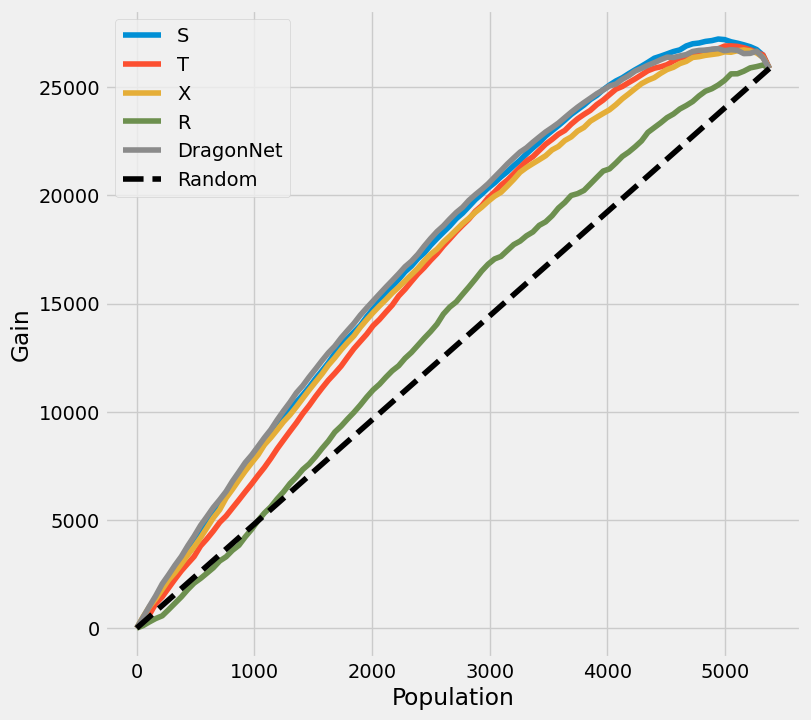

In [12]:
plot_gain(df_preds_train)

# DragonNet과 S-leaner 차이가 가장 큰 샘플


In [18]:
diff = dragon_ite - s_ite_train
idx = np.argmax(np.abs(diff))

print('DragonNet: ', dragon_ite[idx])
print('S-leaner: ', s_ite_train[idx])
print(idx)

DragonNet:  [5.9959755]
S-leaner:  [-4.33727723]
105


In [21]:
diff.ravel()

array([ 1.14734029,  1.88835983, -0.00969202, ...,  4.98213891,
        1.93084679, -2.95307543])

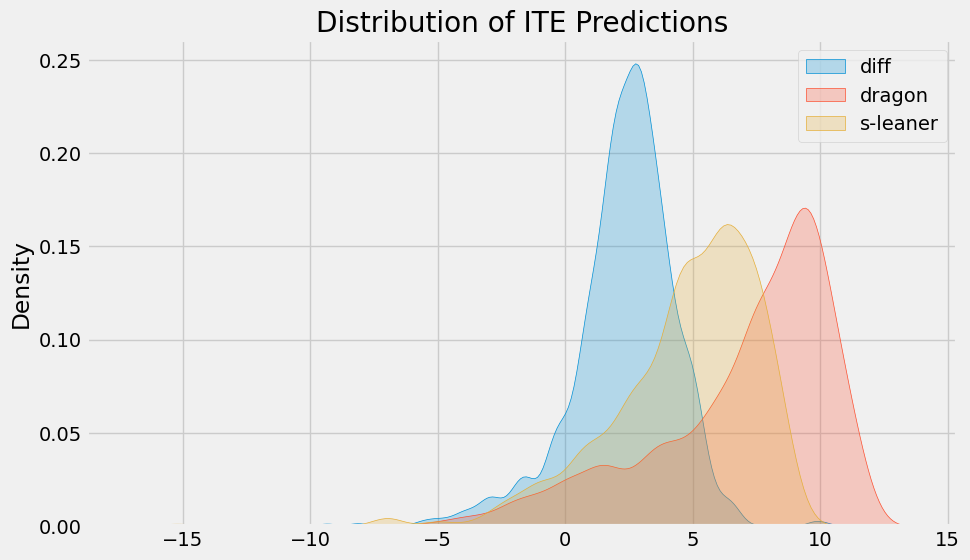

In [23]:
# 그림으로 확인
plt.figure(figsize=(10, 6))
sns.kdeplot(diff.ravel(), label='diff', fill=True)

sns.kdeplot(dragon_ite.ravel(), label='dragon', fill=True)
sns.kdeplot(s_ite_train.ravel(), label='s-leaner', fill=True)

plt.title('Distribution of ITE Predictions')
plt.legend()
plt.show()

차이가 많이 나는 sample을 확인 하려다가 문득...

AUUC는 비슷한데 왜 ATE만 차이가 발생했지?에 초점에 맞춰서 공부를 했습니다.

# AUUC(Area Under the Uplift Curve)
AUUC는 '순서'와 '구분 능력' 이라서 절대적인 크기는 중요하지 않고, 오직 상대적인 순서만이 중요


# ATE(Average Treatment Effect)
ATE는 '크기'와 '평균'으로 모든 사람의 ITE 값을 단순히 평균 낸 값

---
즉, AUUC는 S-leaner = 0.664618, DeagonNet = 0.669309 으로 둘다 순서는 잘 맞춘 것 같습니다.

만약, 모델을 하나 고른다면 ITE의 분산이 적은 S-leaner를 고를 것 같습니다.

In [24]:
np.std(dragon_ite.ravel())

np.float32(3.528176)

In [25]:
np.std(s_ite_train.ravel())

np.float64(3.0650824723749075)